# Marker Model Training

In [1]:
%matplotlib inline
import os
import os.path as osp
import celldom
import pandas as pd
import numpy as np
from cvutils import rectlabel
import matplotlib.pyplot as plt
import imgaug
from sklearn.model_selection import train_test_split
from celldom.config import marker_config
from celldom.dataset import marker_dataset
from mrcnn import model as mrcnn_model_lib
from mrcnn import visualize as mrcnn_viz
from celldom.dataset import utils as dataset_utils
from cvutils.mrcnn.session import init_keras_session
from celldom.warnings import disable_mrcnn_warnings
from cvutils.mrcnn import model as mrcnn_model
from celldom import seed

init_keras_session()
disable_mrcnn_warnings()
plt.gray()

marker_data_dir = osp.join(celldom.get_dataset_dir(), 'training', 'marker', 'r0.6')

model_dir = osp.join(celldom.get_model_dir(), 'marker_model')

Using TensorFlow backend.


<Figure size 432x288 with 0 Axes>

In [2]:
marker_data_dir

'/lab/data/celldom/dataset/training/marker/r0.6'

In [3]:
images = dataset_utils.get_data_files(marker_data_dir, patterns=['*.tif'])
print('Number of annotations found =', len(images))
images[:3]

Number of annotations found = 80


,image_name,image_path,annot_path,annot_exists
68,BFF_16X_St_000_Apt_008_201806301621.tif,/lab/data/celldom/dataset/training/marker/r0.6...,/lab/data/celldom/dataset/training/marker/r0.6...,True
19,BFF_16X_St_000_Apt_018_201806192258.tif,/lab/data/celldom/dataset/training/marker/r0.6...,/lab/data/celldom/dataset/training/marker/r0.6...,True
3,BFF_16X_St_000_Apt_020_201806151149.tif,/lab/data/celldom/dataset/training/marker/r0.6...,/lab/data/celldom/dataset/training/marker/r0.6...,True


In [4]:
images['annot_exists'].value_counts()

True    80
Name: annot_exists, dtype: int64

In [5]:
assert images['annot_exists'].all()

In [6]:
idx_train, idx_test = train_test_split(np.arange(len(images)), test_size=.3, random_state=seed)
assert len(idx_train) + len(idx_test) == len(images)
assert len(np.intersect1d(idx_train, idx_test)) == 0

image_paths_train = images['image_path'].iloc[idx_train].values#[[1]]
image_paths_test = images['image_path'].iloc[idx_test].values#[[0]]

In [7]:
dataset_train = marker_dataset.MarkerDataset()
dataset_train.initialize(image_paths_train)
dataset_train.prepare()

dataset_test = marker_dataset.MarkerDataset()
dataset_test.initialize(image_paths_test)
dataset_test.prepare()

In [8]:
dataset_train.load_image(0).shape, dataset_train.load_image(0).dtype

((1200, 1600, 3), dtype('uint8'))

In [9]:
dataset_train.load_mask(0)[0].shape

(1200, 1600, 14)

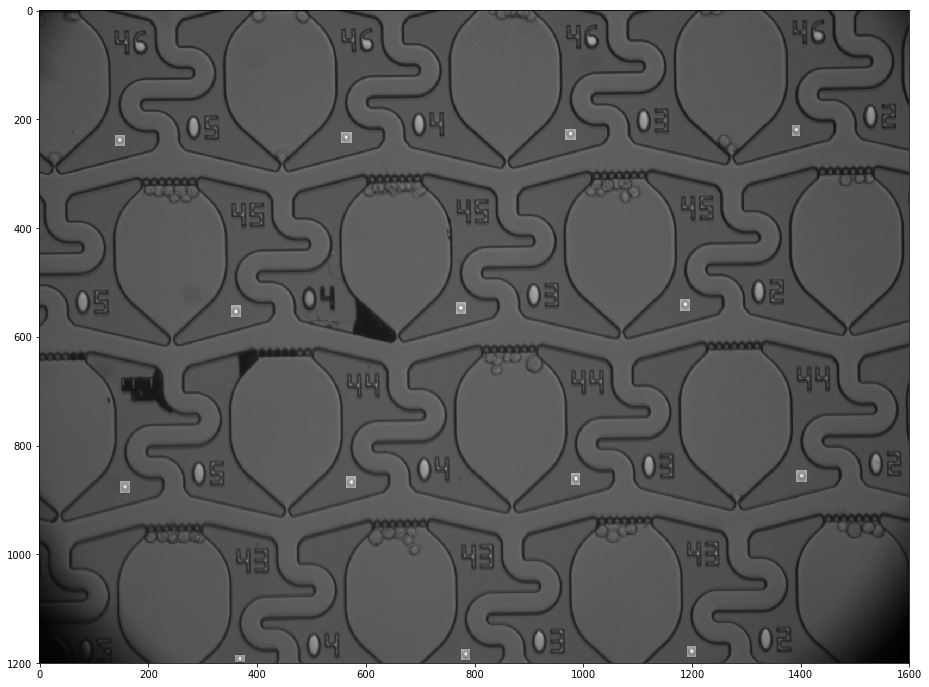

In [13]:
image_id = 0
alpha = .5
plt.imshow(
    dataset_train.load_image(image_id)[..., 0] + \
    alpha * 255 * dataset_train.load_mask(image_id)[0].max(axis=2)
)
plt.gcf().set_size_inches(16, 12)

In [14]:
# Fetch RCNN training configuration
train_config = marker_config.MarkerTrainingConfig()

# Set these step counts to equal data size so that a single epoch is easier to describe
train_config.STEPS_PER_EPOCH = len(image_paths_train)
train_config.VALIDATION_STEPS = len(image_paths_test)
    
train_config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        50
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
EXPECTED_CLASS_COUNTS          {'Marker': 1}
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'mrcnn_mask_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'rpn_bbox_loss': 1.0, 'rpn_class_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE   

In [15]:
model_dir

'/lab/data/celldom/model/r0.6/marker_model'

In [16]:
model = mrcnn_model.get_model(mode="training", config=train_config, model_dir=model_dir, init_with='coco')

In [17]:
import wandb
wandb.init()

W&B Run: https://app.wandb.ai/hammerlab/celldom/runs/zhkapsu3
Wrap your training loop with `with wandb.monitor():` to display live results.


W&B Run https://app.wandb.ai/hammerlab/celldom/runs/zhkapsu3

In [18]:
aug = imgaug.augmenters.Sometimes(0.5, [
    imgaug.augmenters.Fliplr(p=0.5),
    imgaug.augmenters.Affine(rotate=(-15, 15))
])

In [19]:
%%time
from wandb.keras import WandbCallback

with wandb.monitor(display=False):
    # Classifier heads only
    model.train(
        dataset_train, dataset_test, 
        learning_rate=train_config.LEARNING_RATE, 
        epochs=30, 
        augmentation=aug,
        custom_callbacks=[WandbCallback(save_model=False)],
        layers='heads'
    )
    # Fine-tuning
    model.train(
        dataset_train, dataset_test, 
        learning_rate=train_config.LEARNING_RATE, 
        epochs=60, 
        augmentation=aug,
        custom_callbacks=[WandbCallback(save_model=False)],
        layers='all'
    )

Resuming run: https://app.wandb.ai/hammerlab/celldom/runs/zhkapsu3


Instructions for updating:
Use the retry module or similar alternatives.

Starting at epoch 0. LR=0.001

Checkpoint Path: /lab/data/celldom/model/r0.6/marker_model/celldom-marker20180906T1830/mask_rcnn_celldom-marker_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeD

In [ ]:
#plt.plot(model.keras_model.history.history['val_loss'])

In [24]:
!find $model_dir | tail

/lab/data/celldom/model/r0.6/marker_model/celldom-marker20180906T1830/mask_rcnn_celldom-marker_0052.h5
/lab/data/celldom/model/r0.6/marker_model/celldom-marker20180906T1830/mask_rcnn_celldom-marker_0053.h5
/lab/data/celldom/model/r0.6/marker_model/celldom-marker20180906T1830/mask_rcnn_celldom-marker_0054.h5
/lab/data/celldom/model/r0.6/marker_model/celldom-marker20180906T1830/mask_rcnn_celldom-marker_0055.h5
/lab/data/celldom/model/r0.6/marker_model/celldom-marker20180906T1830/mask_rcnn_celldom-marker_0056.h5
/lab/data/celldom/model/r0.6/marker_model/celldom-marker20180906T1830/mask_rcnn_celldom-marker_0057.h5
/lab/data/celldom/model/r0.6/marker_model/celldom-marker20180906T1830/mask_rcnn_celldom-marker_0058.h5
/lab/data/celldom/model/r0.6/marker_model/celldom-marker20180906T1830/mask_rcnn_celldom-marker_0059.h5
/lab/data/celldom/model/r0.6/marker_model/celldom-marker20180906T1830/mask_rcnn_celldom-marker_0060.h5
/lab/data/celldom/model/r0.6/marker_model/marker_model.h5


In [25]:
model_dir

'/lab/data/celldom/model/r0.6/marker_model'

In [26]:
model_path = osp.join(model_dir, 'marker_model.h5')
!cp $model_dir/celldom-marker20180906T1830/mask_rcnn_celldom-marker_0060.h5 $model_path
'Final model copied to result path "{}"'.format(model_path)

'Final model copied to result path "/lab/data/celldom/model/r0.6/marker_model/marker_model.h5"'

In [18]:
# model_path = '/lab/data/celldom/model/r0.2/marker_model/celldom-marker20180606T1147/mask_rcnn_celldom-marker_0015.h5'

## Inference

In [10]:
model_path = osp.join(model_dir, 'marker_model.h5')

In [11]:
model_path

'/lab/data/celldom/model/r0.6/marker_model/marker_model.h5'

In [12]:
# Re-initialize model from exported weights in inference mode
inference_config = marker_config.MarkerInferenceConfig()

In [13]:
inference_config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        50
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
EXPECTED_CLASS_COUNTS          {'Marker': 1}
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'mrcnn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE   

In [14]:
model = mrcnn_model.get_model('inference', inference_config, model_dir, init_with='file', file=model_path)

In [15]:
len(dataset_test.image_ids)

24

In [16]:
images.head()

,image_name,image_path,annot_path,annot_exists
68,BFF_16X_St_000_Apt_008_201806301621.tif,/lab/data/celldom/dataset/training/marker/r0.6...,/lab/data/celldom/dataset/training/marker/r0.6...,True
19,BFF_16X_St_000_Apt_018_201806192258.tif,/lab/data/celldom/dataset/training/marker/r0.6...,/lab/data/celldom/dataset/training/marker/r0.6...,True
3,BFF_16X_St_000_Apt_020_201806151149.tif,/lab/data/celldom/dataset/training/marker/r0.6...,/lab/data/celldom/dataset/training/marker/r0.6...,True
52,BFF_16X_St_000_Apt_036_201806221837.tif,/lab/data/celldom/dataset/training/marker/r0.6...,/lab/data/celldom/dataset/training/marker/r0.6...,True
1,BFF_16X_St_003_Apt_044_201806301630.tif,/lab/data/celldom/dataset/training/marker/r0.6...,/lab/data/celldom/dataset/training/marker/r0.6...,True


In [17]:
def show_prediction(image_id):
    image, image_meta, gt_class_id, gt_bbox, gt_mask = \
    mrcnn_model_lib.load_image_gt(
        dataset_test, inference_config, image_id,
        use_mini_mask=False
    )
    r = model.detect([image])[0]
    mrcnn_viz.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_test.class_names, r['scores'], show_bbox=True, show_mask=False)

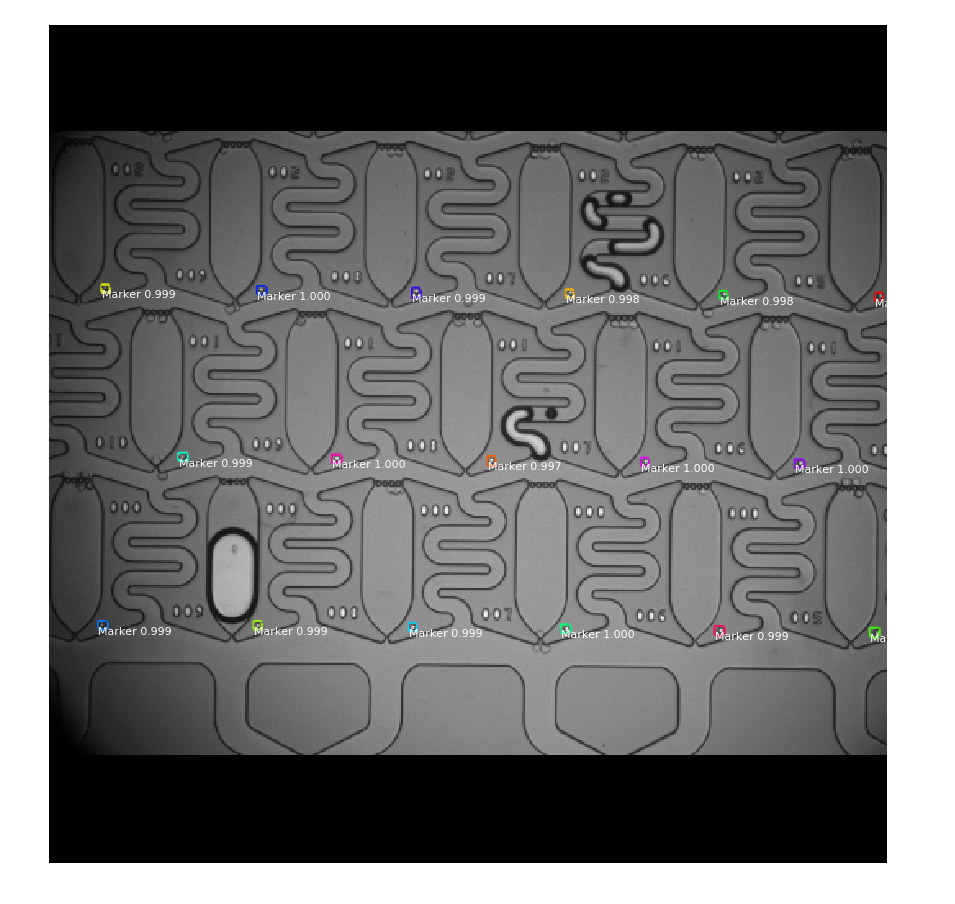

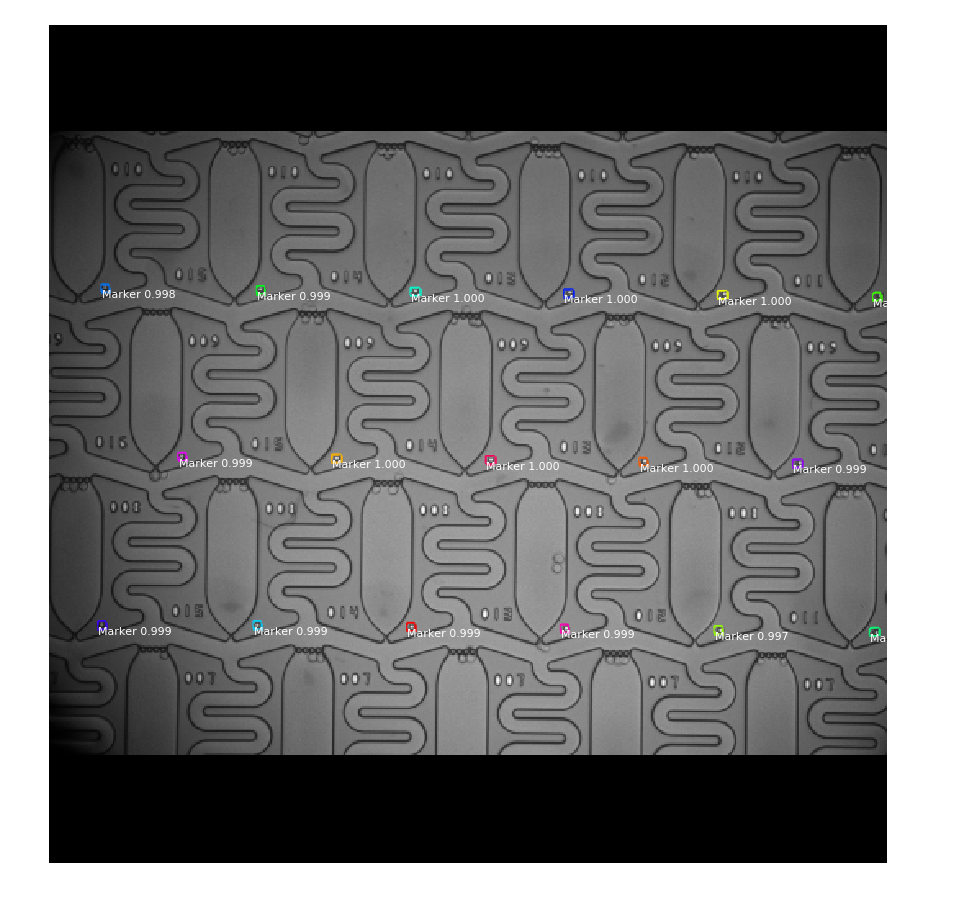

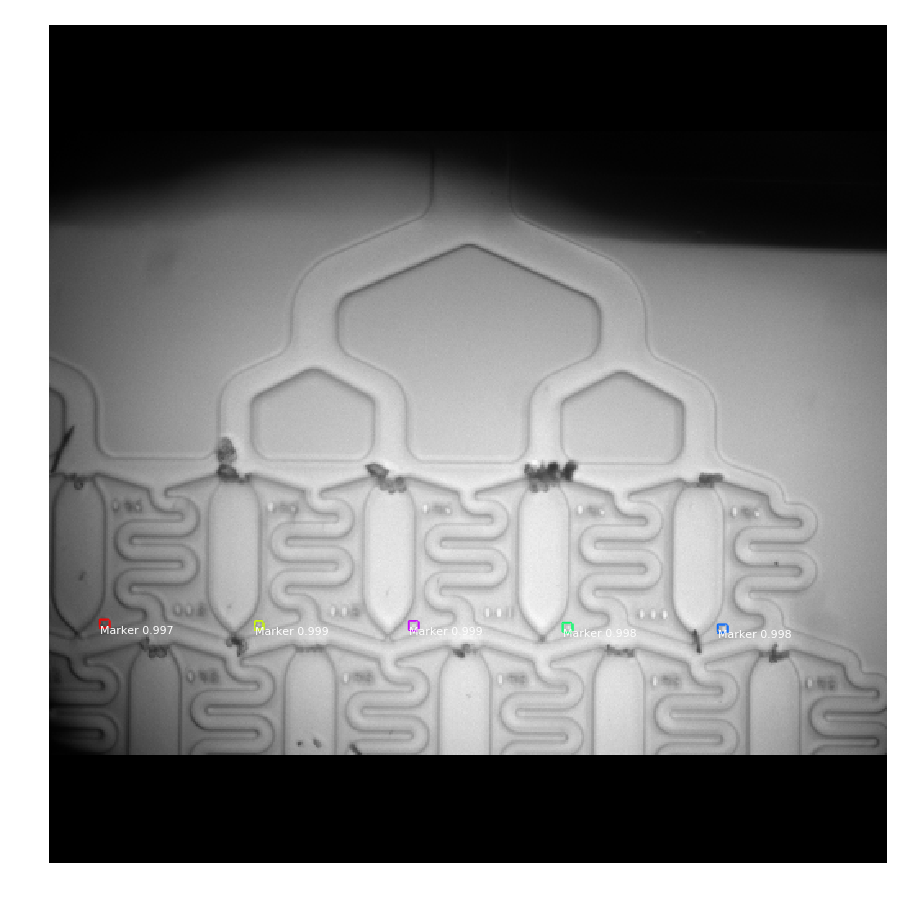

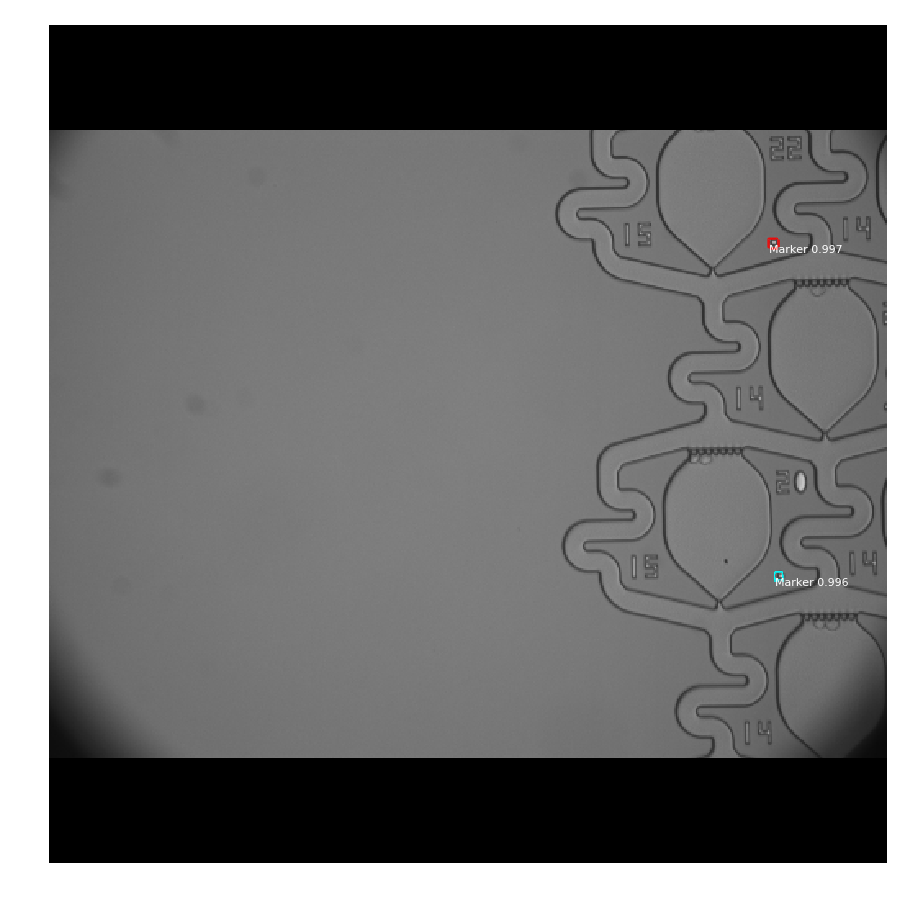

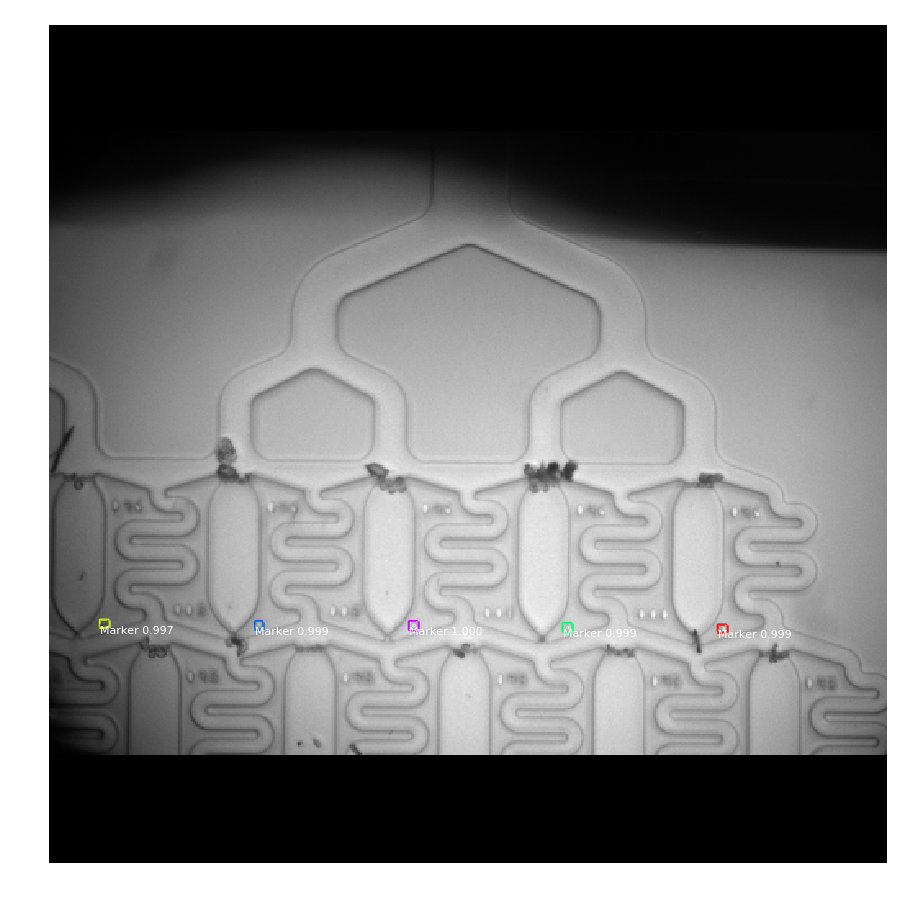

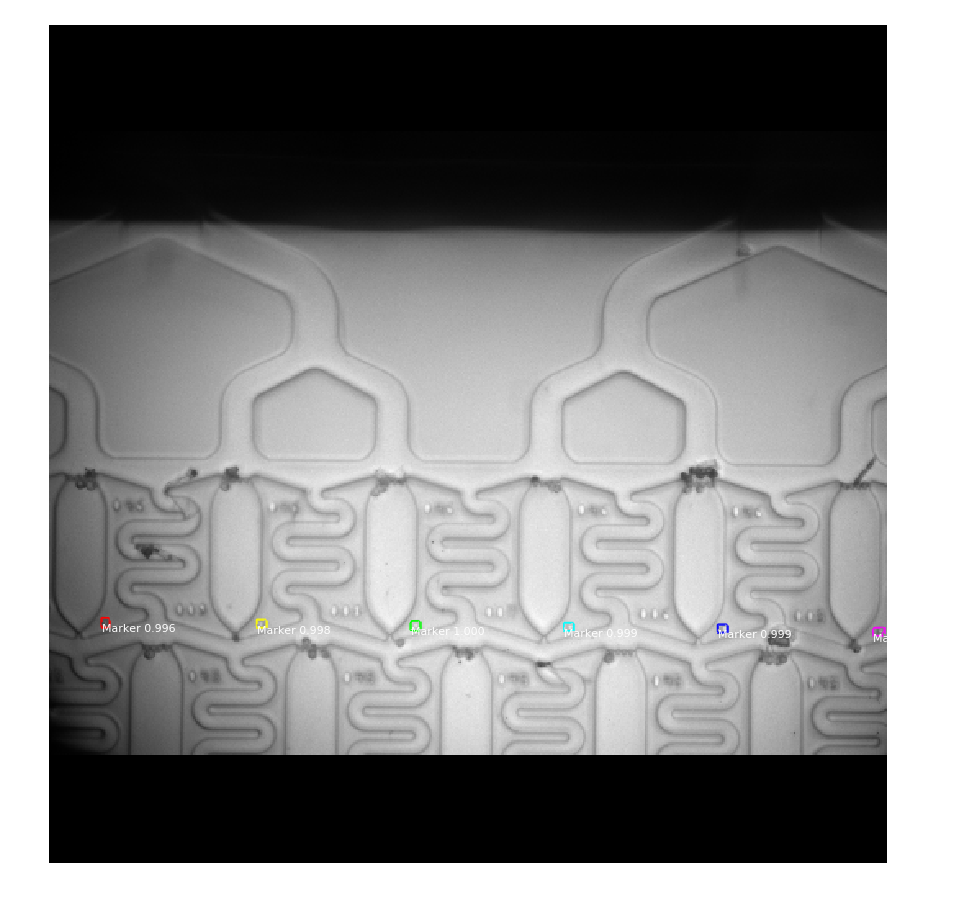

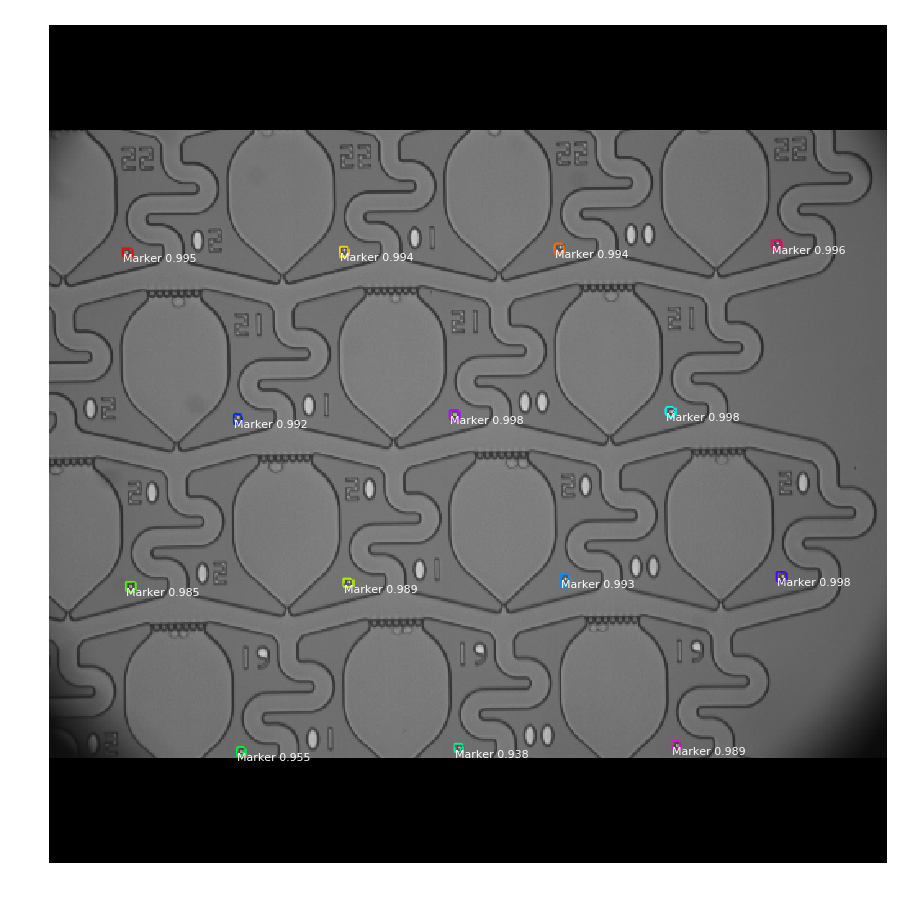

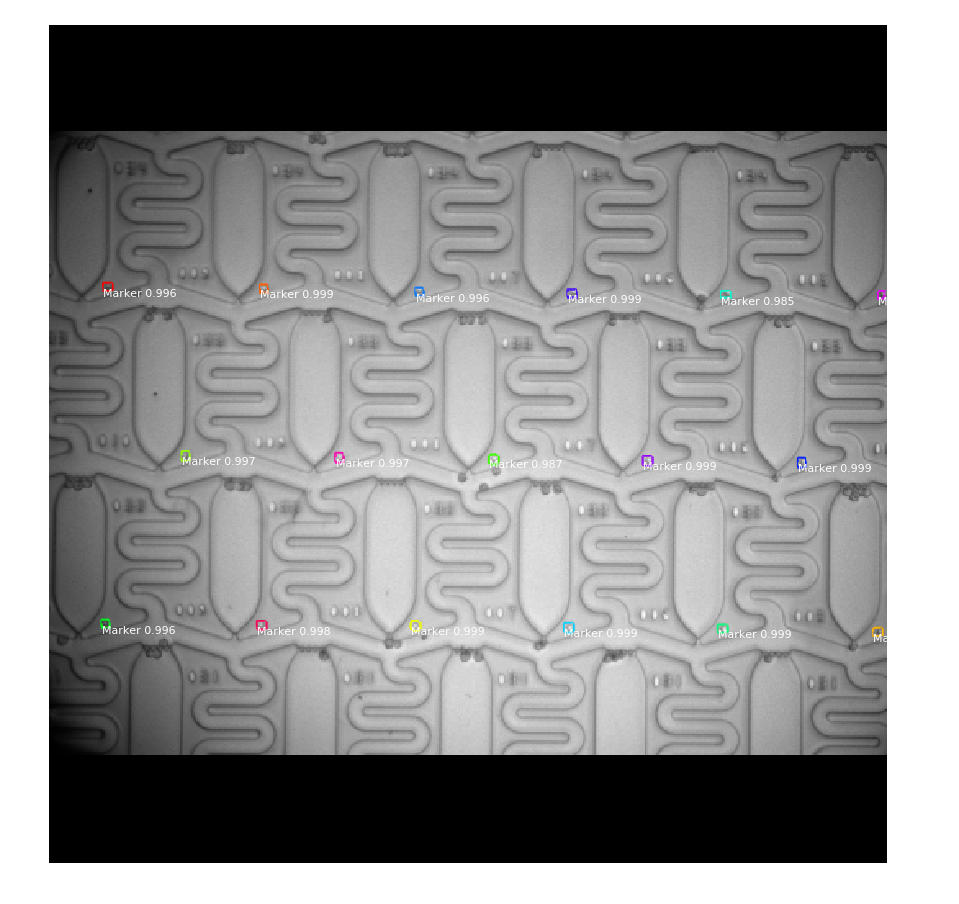

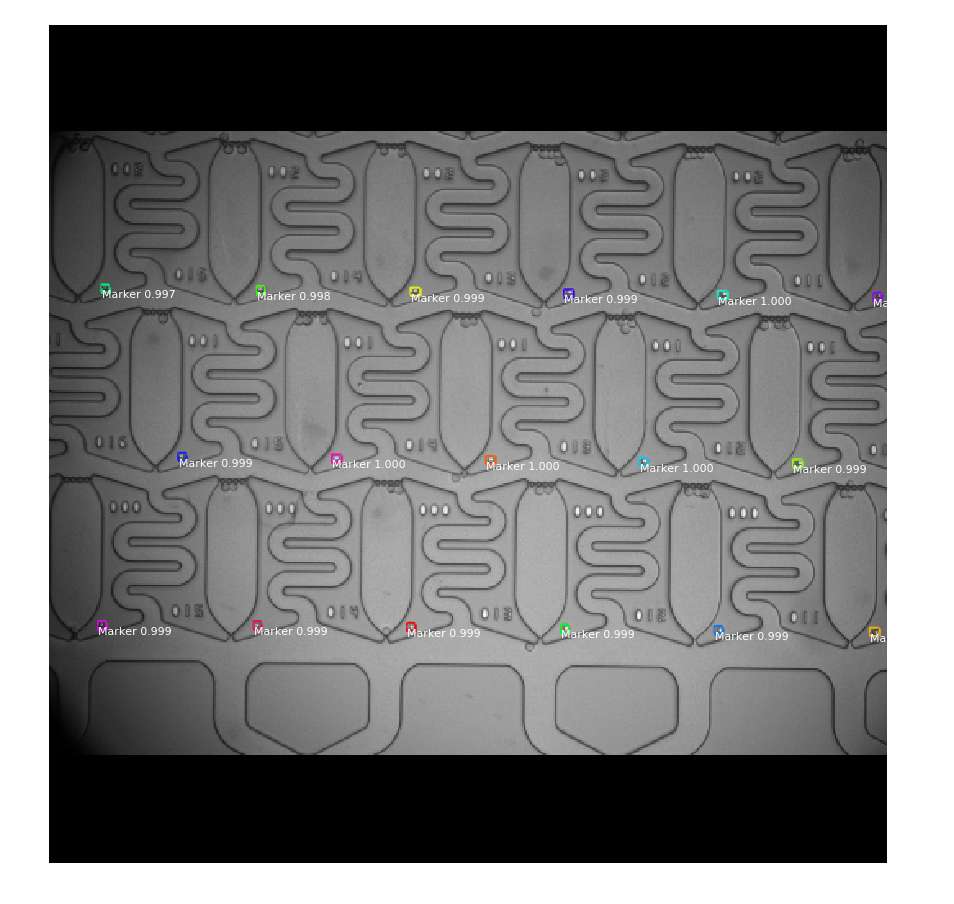

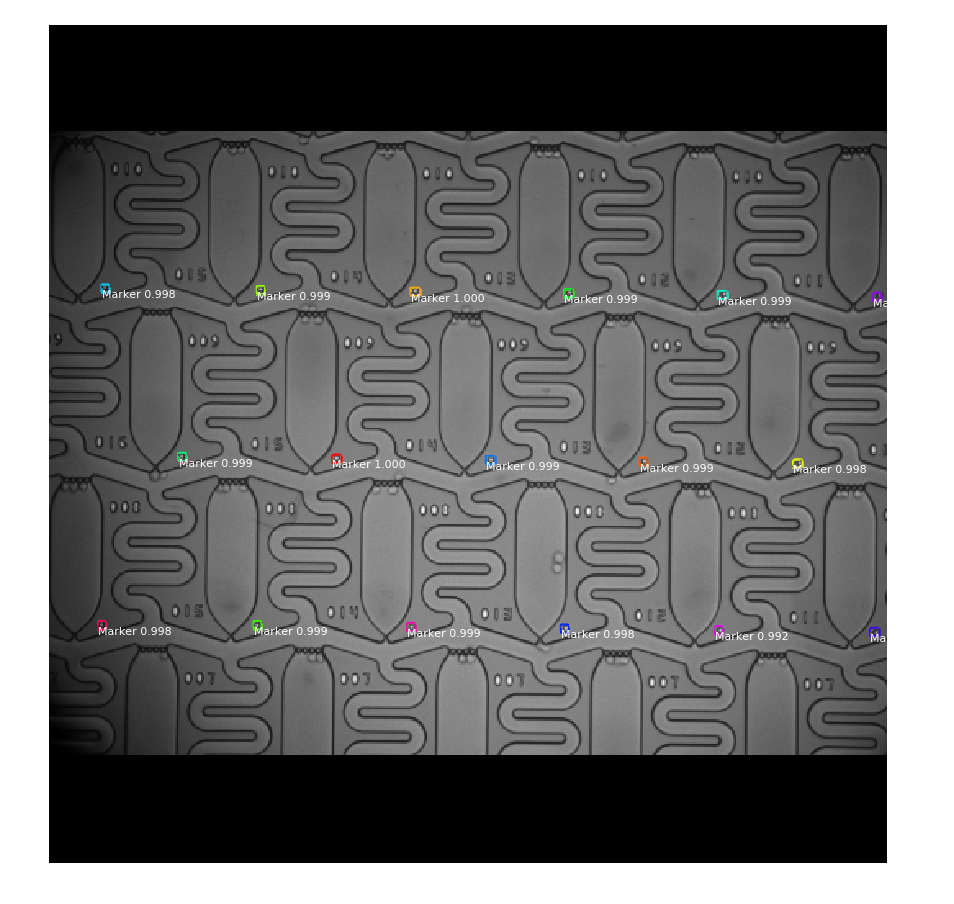

CPU times: user 10.7 s, sys: 7.15 s, total: 17.9 s
Wall time: 9.52 s


In [28]:
%%time
image_ids = pd.Series(dataset_test.image_ids).sample(n=10)
for iid in image_ids:
    show_prediction(iid)

In [18]:
image_id = 8
image, image_meta, gt_class_id, gt_bbox, gt_mask = \
mrcnn_model_lib.load_image_gt(
    dataset_test, inference_config, image_id,
    use_mini_mask=False
)

In [21]:
%%time
r = model.detect([dataset_test.load_image(image_id)])[0]

CPU times: user 283 ms, sys: 338 ms, total: 621 ms
Wall time: 226 ms


In [22]:
r['masks'].shape

(1200, 1600, 13)

In [23]:
r['rois']

array([[ 535, 1180,  551, 1194],
       [ 544,  765,  560,  781],
       [ 850, 1395,  867, 1411],
       [ 230,  553,  246,  569],
       [1175, 1195, 1189, 1209],
       [ 238,  138,  255,  155],
       [ 214, 1381,  231, 1397],
       [ 876,  149,  892,  165],
       [ 223,  965,  240,  982],
       [ 866,  565,  883,  581],
       [ 858,  979,  874,  993],
       [ 551,  353,  567,  367],
       [1181,  780, 1195,  793]], dtype=int32)

In [24]:
image_meta

array([8.00e+00, 1.20e+03, 1.60e+03, 3.00e+00, 5.12e+02, 5.12e+02,
       3.00e+00, 6.40e+01, 0.00e+00, 4.48e+02, 5.12e+02, 3.20e-01,
       1.00e+00, 1.00e+00])

In [ ]:
# To validate mrcnn resizing:
# from mrcnn import utils as mrcnn_utils
# rsz_img_res, rsz_window, rsz_scale, rsz_padding, rsz_crop = mrcnn_utils.resize_image(rsz_img, min_dim=1024, max_dim=1408, min_scale=0)
# # image.astype(image_dtype), window, scale, padding, crop
# rsz_img_res.shape, rsz_window, rsz_scale, rsz_padding, rsz_crop